# Logistic Regression Models

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, recall_score

from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from scipy import stats
import statsmodels.api as sm

In [2]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [3]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [4]:
def na_check(data):
    check = np.round(data.isna().sum().sort_values(ascending=False),2)
    return check

In [5]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = pd.read_csv('data/preprocessed.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,0,42536,10129454,12000.0,36 months,10.99%,392.8,B,B2,4,...,0.0,4.0,100.0,0.0,0.0,7137.0,18100.0,0.0,N,N
1,1,42537,10149488,4800.0,36 months,10.99%,157.1,B,B2,2,...,0.0,0.0,100.0,0.0,0.0,4136.0,25700.0,0.0,N,N
2,2,42538,10149342,27060.0,36 months,10.99%,885.5,B,B2,10,...,0.0,1.0,100.0,0.0,0.0,70186.0,35700.0,33054.0,N,N
3,3,42539,10148122,12000.0,36 months,7.62%,374.0,A,A3,3,...,0.0,3.0,100.0,0.0,0.0,46738.0,14800.0,53404.0,N,N
4,4,42540,10129477,14000.0,36 months,12.85%,470.8,B,B4,4,...,0.0,0.0,78.6,1.0,0.0,17672.0,3900.0,27340.0,N,N


In [7]:
df.drop(columns=['pymnt_plan','out_prncp','Unnamed: 0','Unnamed: 0.1','id'],axis=1,inplace=True)

In [8]:
df.drop(columns=["debt_settlement_flag", "hardship_flag",],axis=1,inplace=True)

In [9]:
# making average fico score and dropping the fico range high and low
df['average_fico'] = (df['fico_range_high'] + df['fico_range_low'])/2
df.drop(columns=['fico_range_high','fico_range_low'],axis=1,inplace=True)

In [10]:
df.drop('initial_list_status',axis=1,inplace=True)

In [11]:
df.drop('title',axis=1,inplace=True)

In [12]:
df.drop(columns=['zip_code'],axis=1,inplace=True)

In [13]:
df.int_rate = df.int_rate.map(lambda x: float(x.replace('%','')))

In [14]:
regions = pd.read_excel('data/state_regions.xlsx')

In [15]:
df['region'] = df.addr_state.apply(lambda x: regions.loc[regions['State Code'] == x]['Region'].values[0])

In [16]:
df.drop(columns = ['addr_state'],axis=1,inplace=True)

In [17]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/64 [00:00<?, ?it/s]

Memory usage of dataframe is 848.11 MB


100%|██████████| 64/64 [00:06<00:00,  9.26it/s]


Memory usage after optimization is: 511.850 MB
Decreased by 39.6%


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,12000.0,36 months,10.99,392.799988,B,B2,4,RENT,60000.0,Not Verified,...,0.0,4.0,100.000000,0.0,0.0,7137.0,18100.0,0.0,722.0,South
1,4800.0,36 months,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,Source Verified,...,0.0,0.0,100.000000,0.0,0.0,4136.0,25700.0,0.0,757.0,South
2,27060.0,36 months,10.99,885.500000,B,B2,10,OWN,55000.0,Verified,...,0.0,1.0,100.000000,0.0,0.0,70186.0,35700.0,33054.0,732.0,Midwest
3,12000.0,36 months,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,Not Verified,...,0.0,3.0,100.000000,0.0,0.0,46738.0,14800.0,53404.0,707.0,South
4,14000.0,36 months,12.85,470.799988,B,B4,4,RENT,88000.0,Not Verified,...,0.0,0.0,78.599998,1.0,0.0,17672.0,3900.0,27340.0,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,24000.0,60 months,23.99,690.500000,E,E2,1,RENT,107000.0,Source Verified,...,1.0,2.0,87.500000,1.0,1.0,60812.0,28200.0,64422.0,672.0,West
1736933,10000.0,36 months,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,Source Verified,...,0.0,2.0,92.599998,0.0,0.0,55863.0,34800.0,70203.0,727.0,Northeast
1736934,10050.0,36 months,16.99,358.200012,D,D1,8,RENT,37000.0,Not Verified,...,0.0,5.0,95.199997,0.0,0.0,14300.0,9000.0,0.0,707.0,South
1736935,6000.0,36 months,11.44,197.800003,B,B4,5,RENT,41000.0,Source Verified,...,0.0,1.0,94.400002,0.0,0.0,26201.0,8100.0,34076.0,672.0,Northeast


In [19]:
post_app_drops = ['total_bal_ex_mort', 'pct_tl_nvr_dlq','num_tl_op_past_12m','num_tl_90g_dpd_24m','num_tl_30dpd'
,'num_tl_120dpd_2m','num_bc_sats','num_accts_ever_120_pd','mths_since_recent_bc','mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op'
,'chargeoff_within_12_mths','bc_util','avg_cur_bal','tot_cur_bal','tot_coll_amt','acc_now_delinq','collections_12_mths_ex_med'
,'last_pymnt_amnt','recoveries','total_rec_late_fee'
,'total_rec_int','total_rec_prncp','total_pymnt','revol_util','revol_bal']

In [18]:
df.drop(columns=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d','last_fico_range_high','last_fico_range_low'],axis=1,inplace=True)

In [19]:
df.term = df.term.map(lambda x: np.int8(x.replace(' months','')))

In [20]:
df.revol_util = df.revol_util.map(lambda x: float(x.replace('%','')))

In [ ]:
## from model testing these features are not relevant and total pymnt,prncp, and int would be a posteori knowledge so can't use
df.drop(columns=['total_rec_int','total_rec_prncp','total_pymnt',
                 'tot_coll_amt','num_il_tl','delinq_amnt','tax_liens','last_pymnt_amnt'],axis=1,inplace=True)

In [47]:
df.to_csv('data/full_clean_pre_z')

**Start Here loading DF**

In [6]:
df = pd.read_csv('data/full_clean_pre_z')
df.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,0,12000.0,36,10.99,392.8,B,B2,4,RENT,60000.0,...,0.0,0.0,4.0,100.0,0.0,7137.0,18100.0,0.0,722.0,South
1,1,4800.0,36,10.99,157.1,B,B2,2,MORTGAGE,39600.0,...,0.0,0.0,0.0,100.0,0.0,4136.0,25700.0,0.0,757.0,South
2,2,27060.0,36,10.99,885.5,B,B2,10,OWN,55000.0,...,0.0,0.0,1.0,100.0,0.0,70186.0,35700.0,33054.0,732.0,Midwest
3,3,12000.0,36,7.62,374.0,A,A3,3,MORTGAGE,96500.0,...,0.0,0.0,3.0,100.0,0.0,46738.0,14800.0,53404.0,707.0,South
4,4,14000.0,36,12.85,470.8,B,B4,4,RENT,88000.0,...,0.0,0.0,0.0,78.6,1.0,17672.0,3900.0,27340.0,672.0,South


In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Memory usage of dataframe is 662.59 MB


100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


Memory usage after optimization is: 374.363 MB
Decreased by 43.5%


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,12000.0,36,10.99,392.799988,B,B2,4,RENT,60000.0,Not Verified,...,0.0,0.0,4.0,100.000000,0.0,7137.0,18100.0,0.0,722.0,South
1,4800.0,36,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,Source Verified,...,0.0,0.0,0.0,100.000000,0.0,4136.0,25700.0,0.0,757.0,South
2,27060.0,36,10.99,885.500000,B,B2,10,OWN,55000.0,Verified,...,0.0,0.0,1.0,100.000000,0.0,70186.0,35700.0,33054.0,732.0,Midwest
3,12000.0,36,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,Not Verified,...,0.0,0.0,3.0,100.000000,0.0,46738.0,14800.0,53404.0,707.0,South
4,14000.0,36,12.85,470.799988,B,B4,4,RENT,88000.0,Not Verified,...,0.0,0.0,0.0,78.599998,1.0,17672.0,3900.0,27340.0,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,24000.0,60,23.99,690.500000,E,E2,1,RENT,107000.0,Source Verified,...,0.0,1.0,2.0,87.500000,1.0,60812.0,28200.0,64422.0,672.0,West
1736933,10000.0,36,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,Source Verified,...,0.0,0.0,2.0,92.599998,0.0,55863.0,34800.0,70203.0,727.0,Northeast
1736934,10050.0,36,16.99,358.200012,D,D1,8,RENT,37000.0,Not Verified,...,0.0,0.0,5.0,95.199997,0.0,14300.0,9000.0,0.0,707.0,South
1736935,6000.0,36,11.44,197.800003,B,B4,5,RENT,41000.0,Source Verified,...,0.0,0.0,1.0,94.400002,0.0,26201.0,8100.0,34076.0,672.0,Northeast


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 50 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float32
 1   term                        int8   
 2   int_rate                    float32
 3   installment                 float32
 4   grade                       object 
 5   sub_grade                   object 
 6   emp_length                  int8   
 7   home_ownership              object 
 8   annual_inc                  float32
 9   verification_status         object 
 10  loan_status                 object 
 11  purpose                     object 
 12  dti                         float32
 13  delinq_2yrs                 float32
 14  inq_last_6mths              float32
 15  pub_rec                     float32
 16  revol_bal                   float32
 17  revol_util                  float32
 18  total_acc                   float32
 19  total_rec_late_fee   

In [10]:
objects = list(df.loc[:,df.dtypes == 'object'].columns)

In [11]:
objects

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'application_type',
 'region']

In [12]:
categorical = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region']


cat_drop = ['sub_grade',
 'grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'region','loan_status']

In [13]:
onehot = pd.get_dummies(df[categorical],drop_first=True)

In [14]:
cont_columns = df.drop(columns=cat_drop).columns

In [15]:
df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<4).all(axis=1)]

In [16]:
z_score_df = df.loc[df_cont_z.index]

In [17]:
onehot_z = pd.get_dummies(z_score_df[categorical],drop_first=True)

In [18]:
cont_z = z_score_df.drop(columns=cat_drop)

In [19]:
xz= pd.concat([cont_z,onehot_z],axis=1)
yz= z_score_df['loan_status'].map(lambda x: 1 if x== "Charged Off" else 0)

In [20]:
x_train_z, x_test_z, y_train_z, y_test_z = train_test_split(xz, yz, test_size=0.3,random_state=42)

In [21]:
cat_index = np.linspace(50,113,num=(113-50)).astype(np.int)
cat_index

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113])

# Using Smote to Oversample Minority Class (do not run)

In [42]:
from imblearn.over_sampling import SMOTENC

In [43]:
smote= SMOTENC(categorical_features=cat_index,k_neighbors=4)
x_smote_z,y_smote_z = smote.fit_sample(x_train_z,y_train_z)

In [44]:
x_smote_z.to_csv('data/x_smote_z')
y_smote_z.to_csv('data/y_smote_z')

In [22]:
x_smote_z = pd.read_csv('data/x_smote_z')
y_smote_z = pd.read_csv('data/y_smote_z')

In [23]:
# as we dropped columns after testing to our original df need to drop from smote so they aren't included in smote modeling
# at end will need to re run smote 
x_smote_z.drop(columns=['total_rec_int','total_rec_prncp','total_pymnt',
                 'tot_coll_amt','num_il_tl','delinq_amnt','tax_liens','last_pymnt_amnt'],axis=1,inplace=True)

In [24]:
reduce_mem_usage(x_smote_z,int_cast=False)

  0%|          | 0/107 [00:00<?, ?it/s]

Memory usage of dataframe is 1327.29 MB


100%|██████████| 107/107 [00:15<00:00,  7.00it/s]


Memory usage after optimization is: 356.632 MB
Decreased by 73.1%


,Unnamed: 0,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,region_Northeast,region_South,region_West
0,0,7750.000000,36,10.990000,253.800003,3,29000.000000,25.200001,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,10000.000000,36,22.910000,386.799988,1,72000.000000,8.200000,1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,2,10000.000000,36,12.990000,337.000000,6,40000.000000,22.500000,0.000000,2.000000,...,0,1,0,0,0,0,0,0,0,0
3,3,5500.000000,36,16.549999,194.899994,4,54224.000000,20.440001,0.000000,2.000000,...,0,0,0,0,0,0,0,0,1,0
4,4,25000.000000,36,14.520000,861.000000,5,75000.000000,24.980000,0.000000,2.000000,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625891,1625891,24366.757812,51,17.206345,707.872986,4,117479.695312,21.083889,0.633242,1.100275,...,0,0,0,0,0,0,0,0,1,0
1625892,1625892,19482.703125,50,15.419235,542.377869,5,51204.097656,22.845705,0.000000,0.602049,...,0,0,0,0,0,0,0,0,0,0
1625893,1625893,13179.145508,36,14.562667,461.734833,6,55000.000000,18.415403,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1625894,1625894,17840.857422,45,21.473141,597.083801,8,54589.417969,23.626722,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [25]:
x_smote_z.drop('Unnamed: 0',axis=1,inplace=True)

In [26]:
y_smote_z.drop('Unnamed: 0',axis=1,inplace=True)

In [27]:
reduce_mem_usage(y_smote_z,int_cast=False)

100%|██████████| 1/1 [00:00<00:00, 62.50it/s]

Memory usage of dataframe is 12.40 MB
Memory usage after optimization is: 1.551 MB
Decreased by 87.5%


,loan_status
0,0
1,1
2,0
3,1
4,1
...,...
1625891,1
1625892,1
1625893,1
1625894,1


In [28]:
scaler = MinMaxScaler()

In [29]:
x_smote_cont_z =  pd.DataFrame(scaler.fit_transform(x_smote_z[cont_columns]),columns=cont_columns)
x_smote_scaled_z = pd.concat([x_smote_cont_z,x_smote_z[onehot.columns]],axis=1)

In [30]:
x_test_z= x_test_z.reset_index().drop('index',axis=1)
x_test_cont_scaled_z = pd.DataFrame(scaler.transform(x_test_z[cont_columns]),columns=cont_columns)
x_test_scaled_z = pd.concat([x_test_cont_scaled_z,x_test_z[onehot.columns]],axis=1)


In [31]:
x_train_final_z, x_val_z, y_train_final_z, y_val_z = train_test_split(x_smote_scaled_z, y_smote_z, test_size=.3,random_state=42)

In [32]:
x_train_z = x_train_z.reset_index().drop('index',axis=1)
x_cont_z =  pd.DataFrame(scaler.fit_transform(x_train_z[cont_columns]),columns=cont_columns)
x_train_scaled_z = pd.concat([x_cont_z,x_train_z[onehot.columns]],axis=1)

In [33]:
y_train_z = y_train_z.reset_index().drop('index',axis=1)

## Logistic Regression Models 


In [34]:
z_score_df[z_score_df.tot_cur_bal ==0]['loan_status'].value_counts(normalize=True)

Fully Paid     0.743649
Charged Off    0.256351
Name: loan_status, dtype: float64

In [35]:
r = ['loan_amnt',
'term',
'int_rate',
'annual_inc',
'emp_length',
'dti',
'total_acc',
 'tot_cur_bal',
  'pct_tl_nvr_dlq',   
 'total_rec_late_fee',
 'mort_acc',
 'mths_since_recent_inq',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'average_fico',
'bc_util',
     'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
     'tot_coll_amt',
     'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'application_type_Joint App',
 'region_Northeast',
 'region_South',
 'region_West']

In [ ]:
for_sure_out = ['pub_rec','tot_coll_amt','num_il_tl','delinq_amnt','tax_liens', 'purpose_medical',
 'purpose_moving','region_Northeast']

In [36]:
balanced_og=['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
 'num_accts_ever_120_pd','num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other','purpose_renewable_energy',
'purpose_small_business','purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']

### Logistic Regression unsmoted without recoveries

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s finished


AUC: 0.7325226073180483
[[238365 118181]
 [ 26610  53407]]
              precision    recall  f1-score   support

           0       0.90      0.67      0.77    356546
           1       0.31      0.67      0.42     80017

    accuracy                           0.67    436563
   macro avg       0.61      0.67      0.60    436563
weighted avg       0.79      0.67      0.70    436563



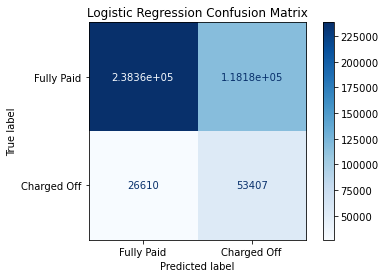

In [37]:
#best log reg using balanced on original data using test features 4std z score drops without recoveries
logreg = LogisticRegression(C=1e7,fit_intercept=True,solver='lbfgs',penalty='l2',max_iter=500,verbose=1,class_weight='balanced')
log_model = logreg.fit(x_train_scaled_z[balanced_og], y_train_z)
y_hat_log = logreg.predict(x_test_scaled_z[balanced_og])
y_score_log = log_model.decision_function(x_test_scaled_z[balanced_og])
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z[balanced_og],y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [38]:
pd.DataFrame(index =x_train_scaled_z[balanced_og].columns,data=log_model.coef_.flatten())

,0
loan_amnt,-0.358589
term,0.682327
int_rate,1.357631
installment,1.091914
emp_length,-0.061001
annual_inc,-0.428104
dti,1.613735
delinq_2yrs,0.139126
inq_last_6mths,0.188970
revol_bal,-0.875154


In [39]:
logit_model=sm.Logit(y_train_z,x_train_scaled_z[balanced_og])
result=logit_model.fit(method='bfgs',maxiter=750)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.424408
         Iterations: 309
         Function evaluations: 310
         Gradient evaluations: 310
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1018645
Model:                          Logit   Df Residuals:                  1018591
Method:                           MLE   Df Model:                           53
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                  0.1087
Time:                        04:09:31   Log-Likelihood:            -4.3232e+05
converged:                       True   LL-Null:                   -4.8503e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Logistic Regression with Recoveries Unsmoted

In [42]:
balanced_og_recoveries =['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs',
 'revol_bal','average_fico','total_acc','total_rec_late_fee','tot_cur_bal','bc_util',
 'mort_acc','mths_since_recent_bc','mths_since_recent_inq',
'num_bc_sats','num_bc_tl','num_op_rev_tl','num_tl_90g_dpd_24m',
'num_tl_op_past_12m','pct_tl_nvr_dlq','pub_rec_bankruptcies','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit',
'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G','home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation',
'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_other',
'purpose_vacation','purpose_wedding','application_type_Joint App', 'region_South','region_West']


C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s finished


AUC: 0.9120173407396552
[[346493  10053]
 [ 21430  58587]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    356546
           1       0.85      0.73      0.79     80017

    accuracy                           0.93    436563
   macro avg       0.90      0.85      0.87    436563
weighted avg       0.93      0.93      0.93    436563



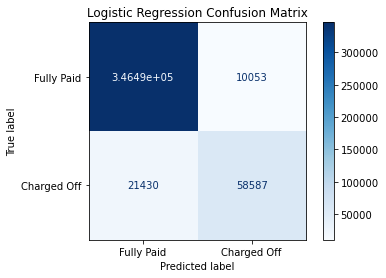

In [43]:
#best log reg using balanced on original data using test features 4std z score drops without recoveries
logreg = LogisticRegression(C=1e7,fit_intercept=False,solver='lbfgs',penalty='l2',max_iter=150,verbose=1,
                            class_weight='balanced')

log_model = logreg.fit(x_train_scaled_z[balanced_og_recoveries], y_train_z)
y_hat_log = logreg.predict(x_test_scaled_z[balanced_og_recoveries])
y_score_log = log_model.decision_function(x_test_scaled_z[balanced_og_recoveries])
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z[balanced_og_recoveries],y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [44]:
# Feature Coefficients for sklearn log reg model
pd.DataFrame(index =x_train_scaled_z[balanced_og_recoveries].columns,data=log_model.coef_.flatten())

,0
recoveries,656.337877
loan_amnt,0.747454
term,0.649438
int_rate,2.783838
installment,-0.199924
emp_length,-0.061298
annual_inc,-1.545751
dti,1.537363
delinq_2yrs,-0.155089
revol_bal,-0.209696


In [45]:
# Our smoted model has different pvalues for various features, so we will drop features that are not stat sig at .05
#confidence level
result.pvalues.sort_values(ascending=False).head(10)

purpose_vacation                0.075808
num_tl_90g_dpd_24m              0.070646
purpose_renewable_energy        0.054241
application_type_Joint App      0.037993
bc_util                         0.002840
region_South                    0.000944
verification_status_Verified    0.000374
purpose_house                   0.000196
delinq_2yrs                     0.000124
grade_G                         0.000033
dtype: float64

In [46]:
logit_model=sm.Logit(y_train_z,x_train_scaled_z[balanced_og_recoveries])
result=logit_model.fit(method='lbfgs',maxiter=750)
print(result.summary())

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1018645
Model:                          Logit   Df Residuals:                  1018595
Method:                           MLE   Df Model:                           49
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                  0.6070
Time:                        04:25:21   Log-Likelihood:            -1.9063e+05
converged:                      False   LL-Null:                   -4.8503e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
recoveries                           5.307e+05   5.11e+04     10.383      0.000     4.3e+05    6.31e+05
loan_amnt                               0.9868      0.13

### Logistic Regression Model for Smoted values with recoveries

In [47]:
recover = ['recoveries',
'loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


AUC: 0.9009224782285918
[[355047   1499]
 [ 24708  55309]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    356546
           1       0.97      0.69      0.81     80017

    accuracy                           0.94    436563
   macro avg       0.95      0.84      0.89    436563
weighted avg       0.94      0.94      0.94    436563



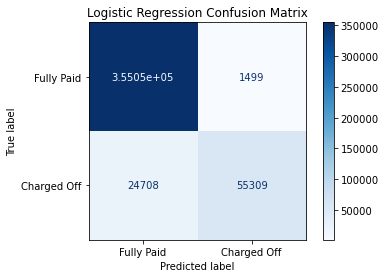

In [48]:
#log reg model including recoveries
logreg = LogisticRegression(C=10,fit_intercept=False,solver='lbfgs',penalty='l2',max_iter=200,verbose=1)
log_model = logreg.fit(x_train_final_z[recover], y_train_final_z.loan_status)
y_hat_log = logreg.predict(x_test_scaled_z[recover])
y_score_log = log_model.decision_function(x_test_scaled_z[recover])
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z[recover],y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [49]:
pd.options.display.max_rows = 85

In [50]:
pd.DataFrame(index= x_train_final_z[recover].columns,data=log_model.coef_.flatten())

,0
recoveries,224.589283
loan_amnt,2.907924
term,0.547196
int_rate,8.724993
installment,-2.477596
emp_length,-0.110124
annual_inc,-1.144473
dti,2.570675
delinq_2yrs,0.210603
inq_last_6mths,0.294931


In [51]:
logit_model=sm.Logit(y_train_final_z,x_train_final_z[recover])
result=logit_model.fit(method='lbfgs',maxiter=250)
print(result.summary())

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1138127
Model:                          Logit   Df Residuals:                  1138045
Method:                           MLE   Df Model:                           81
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                  0.7924
Time:                        04:36:28   Log-Likelihood:            -1.6375e+05
converged:                      False   LL-Null:                   -7.8889e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
recoveries                            407.1083      4.576     88.957      0.000     398.139     416.078
loan_amnt                               3.6465      0.15

### Logistic Regression Model Smoted values, without Recoveries

In [52]:
resamp =['loan_amnt','term','int_rate','installment','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths',
'pub_rec', 'revol_bal','total_acc','total_rec_late_fee','tot_cur_bal','bc_util','mo_sin_rcnt_tl',
 'mths_since_recent_bc', 'num_accts_ever_120_pd',
 'num_bc_sats', 'num_bc_tl',
 'num_op_rev_tl', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
 'total_bal_ex_mort', 'total_bc_limit',
 'total_il_high_credit_limit','average_fico',
 'sub_grade_A2',
 'sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5',
 'sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2',
 'sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1'
,'sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4',
 'sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5',
 'home_ownership_MORTGAGE','home_ownership_OWN','home_ownership_RENT',
'verification_status_Source Verified','verification_status_Verified',
 'purpose_credit_card','purpose_debt_consolidation','purpose_home_improvement','purpose_house','purpose_major_purchase',
'purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation', 'purpose_wedding','purpose_medical',
'purpose_moving',
'application_type_Joint App',
 'region_South','region_West','region_Northeast']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s finished


AUC: 0.6900494207748351
[[329234  27312]
 [ 61123  18894]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88    356546
           1       0.41      0.24      0.30     80017

    accuracy                           0.80    436563
   macro avg       0.63      0.58      0.59    436563
weighted avg       0.76      0.80      0.77    436563



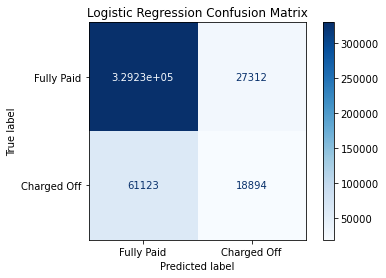

In [54]:
#smote log reg without recoveries
logreg = LogisticRegression(C=.75,fit_intercept=False,solver='saga',penalty='l1',max_iter=500,verbose=1)
log_model = logreg.fit(x_train_final_z[resamp], y_train_final_z.loan_status)
y_hat_log = logreg.predict(x_test_scaled_z[resamp])
y_score_log = log_model.decision_function(x_test_scaled_z[resamp])
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z[resamp],y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [262]:
pd.options.display.max_rows= 85

In [263]:
pd.DataFrame(index =x_train_final_z[resamp].columns,data=log_model.coef_.flatten())

,0
loan_amnt,1.891263
term,0.535819
int_rate,6.995911
installment,-1.193287
emp_length,-0.136702
annual_inc,0.313413
dti,2.583270
delinq_2yrs,0.644501
inq_last_6mths,0.344524
revol_bal,-1.567845


In [55]:
logit_model=sm.Logit(y_train_final_z,x_train_final_z[resamp])
result=logit_model.fit(method='lbfgs',maxiter=750)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1138127
Model:                          Logit   Df Residuals:                  1138044
Method:                           MLE   Df Model:                           82
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                  0.4873
Time:                        04:52:33   Log-Likelihood:            -4.0445e+05
converged:                       True   LL-Null:                   -7.8889e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                               2.1560      0.098     21.990      0.000       1.964       2.348
term                                    0.5027      0.01

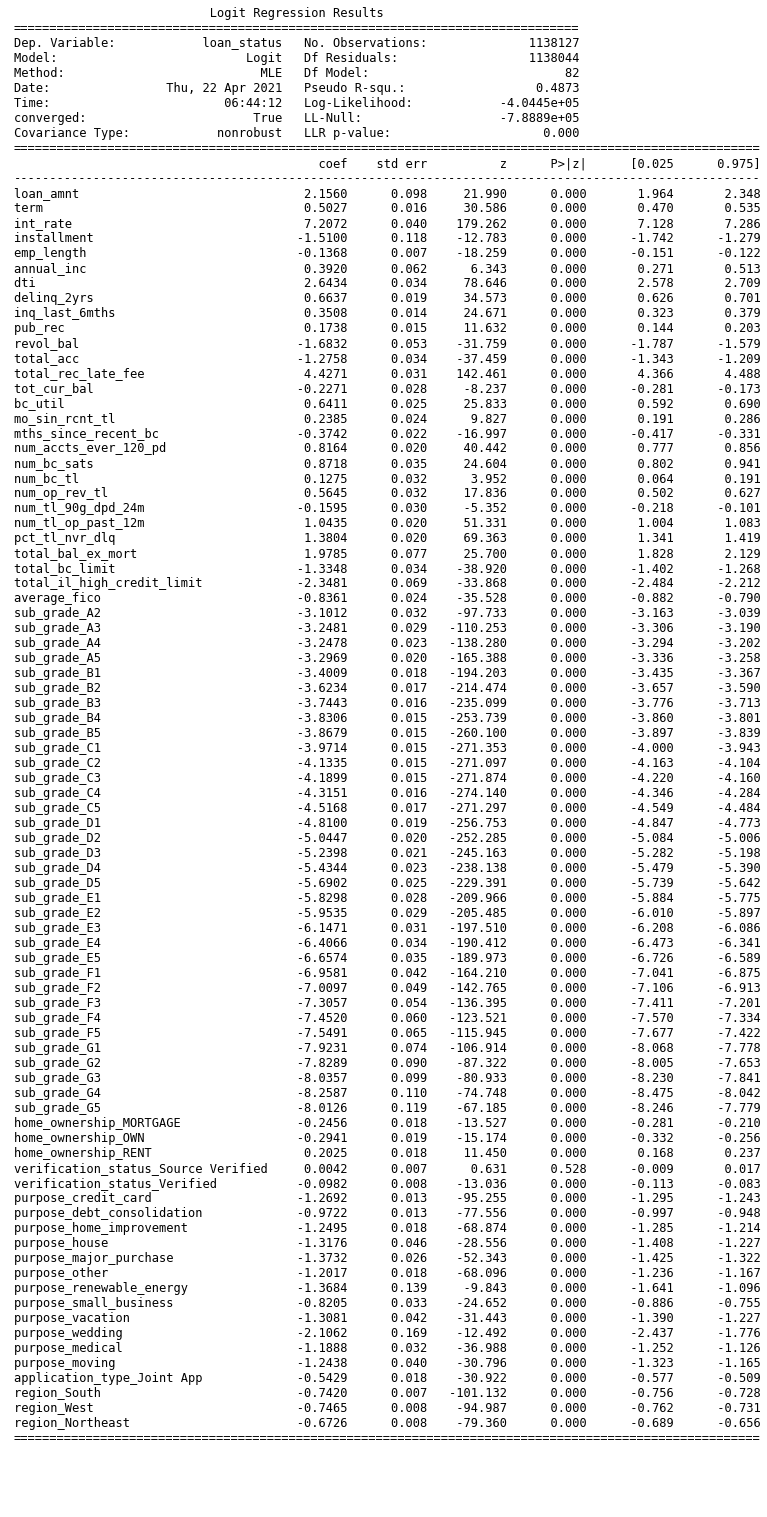

In [73]:

plt.rc('figure', figsize=(12, 25))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 12}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.savefig('log_test.png')

In [ ]:
#smote log reg without recoveries
logreg = LogisticRegression(C=.75,fit_intercept=False,solver='saga',penalty='l1',max_iter=500,verbose=1)
log_model = logreg.fit(x_train_final_z[resamp], y_train_final_z.loan_status)
y_hat_log = logreg.predict(x_test_scaled_z[resamp])
y_score_log = log_model.decision_function(x_test_scaled_z[resamp])
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z[resamp],y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [67]:
log_summary = model_scores(y_test_z,y_hat_log,"Logistic Regression")
log_summary

,Model,precision_score,recall_score,accuracy_score,f1_score
0,Logistic Regression,0.408908,0.236125,0.797429,0.299375


In [68]:
log_summary.to_csv('data/log_scores')

In [65]:
def model_scores(y_true,y_pred,model_name):
    results = ({'Model':model_name,
               'precision_score': precision_score(y_true,y_pred),
               'recall_score': recall_score(y_true,y_pred),
               'accuracy_score': accuracy_score(y_true,y_pred),
               'f1_score': f1_score(y_true,y_pred)})
    model_results = pd.DataFrame(data=results,index=[0])
    return model_results